In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load dataset
file_path = "SRBCT_2.xlsx"
df = pd.read_excel(file_path)

print("Initial dataset shape:", df.shape)

Initial dataset shape: (83, 2309)


In [3]:
# Step 2: Separate features and target (assuming last column is target)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [4]:
# Step 3: Optimized mRMR (using all features)

feature = 5
def optimized_mrmr(X, y, n_features=feature):
    # Calculate mutual information for all features
    relevance = mutual_info_classif(X, y, discrete_features='auto')
    relevance_dict = dict(zip(X.columns, relevance))

    # Compute full correlation matrix once (saves time)
    corr_matrix = X.corr().abs()

    selected_features = []
    remaining_features = list(X.columns)

    # Select first feature (highest relevance)
    first_feature = max(relevance_dict, key=relevance_dict.get)
    selected_features.append(first_feature)
    remaining_features.remove(first_feature)

    print(f"Feature 1 selected: {first_feature}")

    # Iteratively select remaining features
    while len(selected_features) < n_features:
        best_score = -np.inf
        best_feature = None

        for feature in remaining_features:
            rel = relevance_dict[feature]
            # Redundancy: average correlation with selected features (fast lookup)
            redundancy = corr_matrix.loc[feature, selected_features].mean()
            score = rel - redundancy

            if score > best_score:
                best_score = score
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"Feature {len(selected_features)} selected: {best_feature}")

    return selected_features

selected_features = optimized_mrmr(X, y, n_features=feature)
print("\nTop 20 Selected Features (mRMR):")
print(selected_features)

Feature 1 selected: 770394
Feature 2 selected: 784257
Feature 3 selected: 21652
Feature 4 selected: 207274
Feature 5 selected: 246377

Top 20 Selected Features (mRMR):
[770394, 784257, 21652, 207274, 246377]


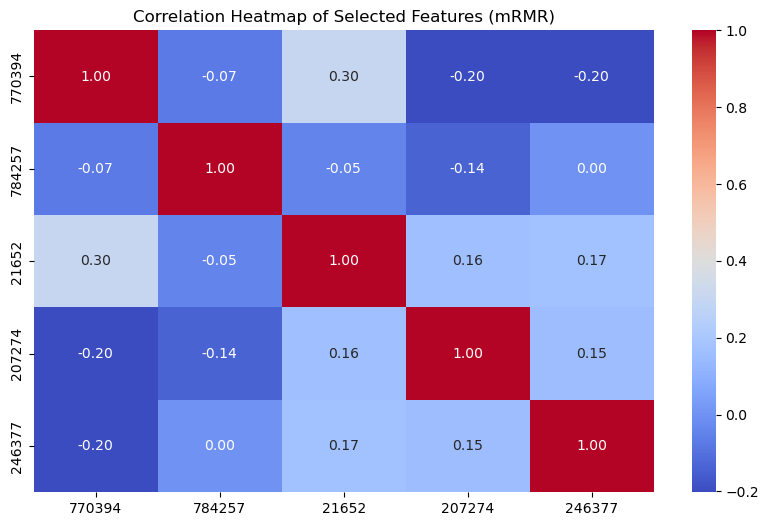

In [5]:
# Visualization 1: Correlation heatmap of selected features
plt.figure(figsize=(10, 6))
sns.heatmap(X[selected_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Selected Features (mRMR)")
plt.show()

In [6]:
# Step 4: Scaling (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X[selected_features]), columns=selected_features)

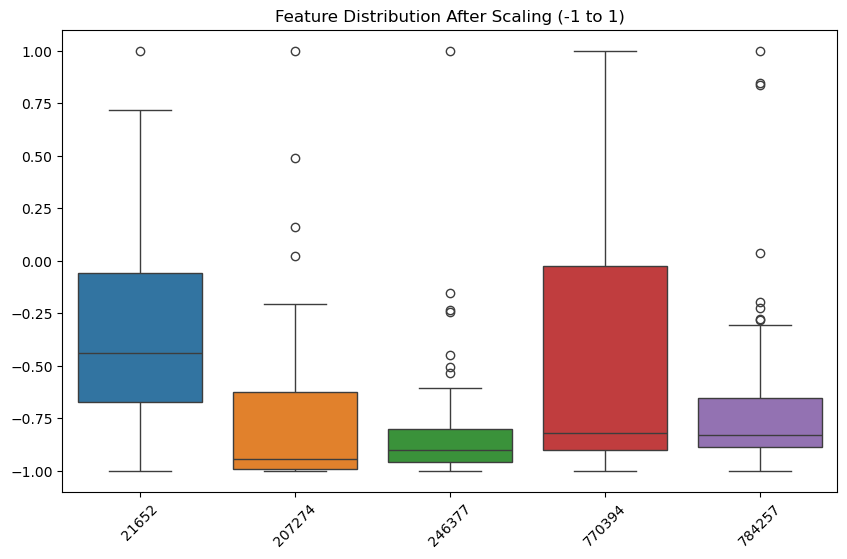

In [7]:
# Visualization 2: Distribution after scaling
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_scaled)
plt.title("Feature Distribution After Scaling (-1 to 1)")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Step 5: Randomize
np.random.seed(42)
shuffled_indices = np.random.permutation(len(X_scaled))
X_randomized = X_scaled.iloc[shuffled_indices].reset_index(drop=True)
y_randomized = y.iloc[shuffled_indices].reset_index(drop=True)

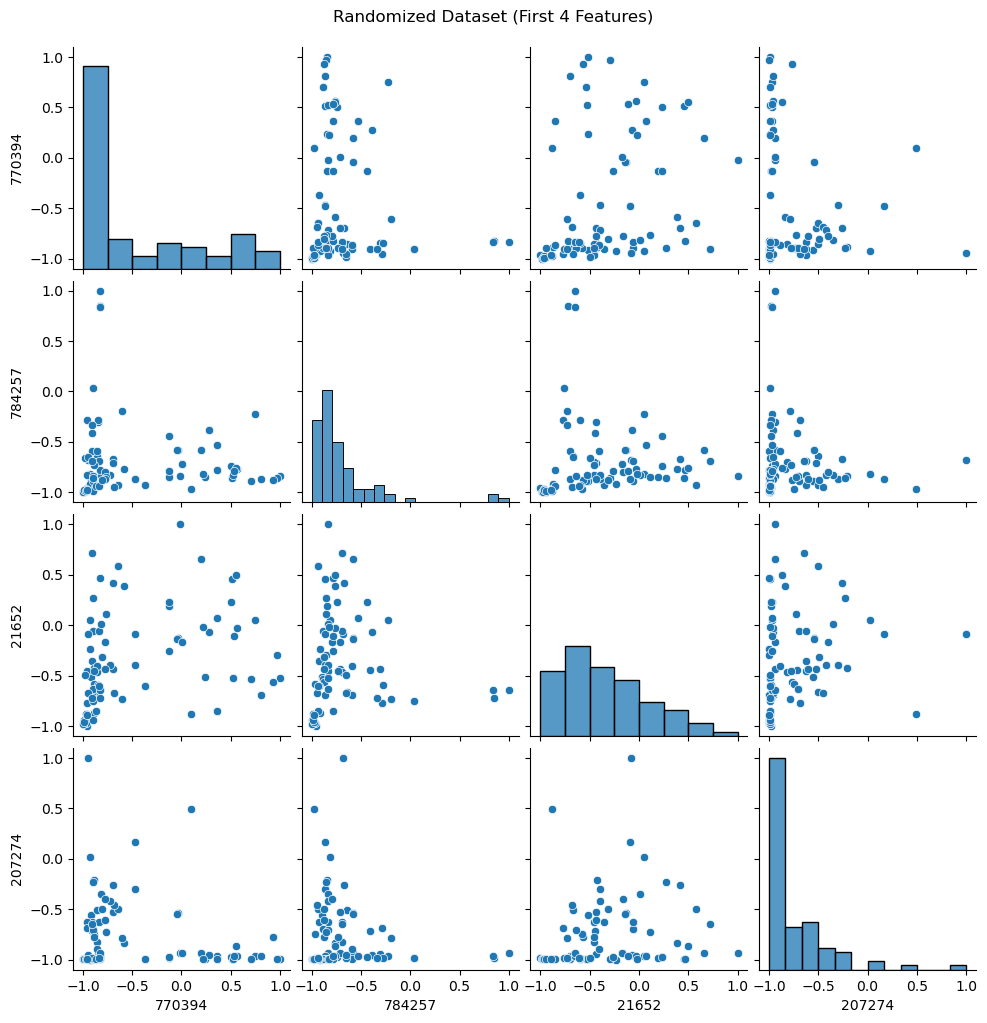

In [9]:
# Visualization 3: Pairplot (first 4 features)
sns.pairplot(X_randomized.iloc[:, :4])
plt.suptitle("Randomized Dataset (First 4 Features)", y=1.02)
plt.show()

In [10]:
print("\nFinal dataset shape after mRMR, scaling, and randomization:", X_randomized.shape)


Final dataset shape after mRMR, scaling, and randomization: (83, 5)


In [11]:
# Combine the processed (randomized) features and target back together
final_dataset = pd.concat([X_randomized, y_randomized.rename("Target")], axis=1)

# Display the final dataset
print("\n✅ Final Processed Dataset (After mRMR, Scaling, and Randomization):")
display(final_dataset.head(20))  # show first 20 rows

print("\nFinal dataset shape:", final_dataset.shape)


✅ Final Processed Dataset (After mRMR, Scaling, and Randomization):


,770394,784257,21652,207274,246377,Target
0,-0.959112,-0.952552,-1.000000,-0.979719,-0.990529,1
1,0.509495,-0.860982,0.462052,-0.989856,-0.819190,0
2,0.239343,-0.846536,-0.512012,-0.995293,-0.974369,0
3,-0.907782,-0.407207,-0.448244,-0.714510,-0.665890,2
4,1.000000,-0.841643,-0.519336,-0.993865,-0.877105,0
5,-0.887280,-0.916417,-0.868918,-0.990298,-0.993235,1
6,0.196657,-0.576957,0.655176,-0.937263,-0.881389,0
7,-0.917726,-0.890618,-0.511965,-0.558722,-0.606772,3
8,0.502113,-0.740834,0.232215,-0.971806,-0.974218,0
9,0.749622,-0.224460,0.046788,-0.966266,-0.885373,0



Final dataset shape: (83, 6)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [13]:
# 1) Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X_randomized,
    y_randomized,
    test_size=0.3,      # 20% for testing
    random_state=42,    # for reproducibility
    stratify=y_randomized  # optional, good for classification
)

# 2) Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 3) Predict and get accuracy
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Total samples: 83
Training samples: 58 (69.88%)
Testing samples: 25 (30.12%)
Random Forest Accuracy: 88.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       1.00      1.00      1.00         3
           2       0.67      0.80      0.73         5
           3       0.89      1.00      0.94         8

    accuracy                           0.88        25
   macro avg       0.89      0.89      0.89        25
weighted avg       0.90      0.88      0.88        25

